In [2]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
target=5
batch_size = 32
input_shape=(2250,1)

In [3]:
import glob
import librosa
import numpy as np

data1 = []
labels1 = []

aorticstenosis = glob.glob('/kaggle/input/15sdataforheartsound/aorticstenosis/New_AS_*.wav')
mitral_regurgitation = glob.glob('/kaggle/input/15sdataforheartsound/mitral regurgitation/New_MR_*.wav')
mitral_stenosis = glob.glob('/kaggle/input/15sdataforheartsound/mitral stenosis/New_MS_*.wav')
mitral_valve_prolapse = glob.glob('/kaggle/input/15sdataforheartsound/mitral valve prolapse/New_MVP_*.wav')
normal = glob.glob('/kaggle/input/15sdataforheartsound/normal/New_N_*.wav')


SAMPLE_RATE=2000

nsample=16000
for file_path in aorticstenosis:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
    #print(signal.shape)
    data1.append(signal)
    labels1.append(0)
    
for file_path in mitral_regurgitation:   
   # print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(1)
    
for file_path in mitral_stenosis:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(2)

for file_path in mitral_valve_prolapse:   
   # print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(3)
    
for file_path in normal:   
    #print(file_path)
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal=np.array(signal[0:nsample])
#     print(signal.shape)
    data1.append(signal)
    labels1.append(4)
   
X= np.array(data1)
y= np.array(labels1)
print(X.shape)

(1000, 2250)


In [12]:
from sklearn.model_selection import train_test_split
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

In [5]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3]), array([126, 129, 128, 129]))

Make the residual block of the WaveNet

# Making two layers of wavenet

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Multiply,Add, Conv1D,AveragePooling2D, Concatenate,Dropout, BatchNormalization, MaxPooling2D, Flatten, Dense,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


# Define the input tensor
inputs = Input(shape=input_shape)

#Convolutional layers

x = Conv1D(64, 2, padding='causal',dilation_rate=1)(inputs)
res= x
x= Conv1D(64, 2, padding='causal',dilation_rate=2)(x)
x1= Conv1D(64, 2, padding='same',activation='sigmoid')(x)
x2= Conv1D(64, 2, padding='same',activation='tanh')(x)
x3= Multiply()([x1,x2])
x4= Conv1D(64, 1,padding='same')(x3)
x5= Add()([x4,res])

x6 = Conv1D(64, 2, padding='causal',dilation_rate=1)(x5)
res= x6
x6= Conv1D(64, 2, padding='causal',dilation_rate=2)(x6)
x7= Conv1D(64, 2, padding='same',activation='sigmoid')(x6)
x8= Conv1D(64, 2, padding='same',activation='tanh')(x6)
x9= Multiply()([x7,x8])
x10= Conv1D(64, 1,padding='same')(x9)
x11= Add()([x10,res])

x12= Add()([x10,x4])
x12= Activation('relu')(x12)
x12= Conv1D(64, 1,padding='same',activation='relu')(x12)
x12= Conv1D(64, 1,padding='same',activation='relu')(x12)

x12= Flatten()(x12)

x12= Dense(10,activation='relu')(x12)
x12= Dropout(0.5)(x12)
x12= Dense(5,activation='relu')(x12)
output = Dense(5, activation='softmax')(x12)

model=Model(inputs=inputs,outputs=output)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

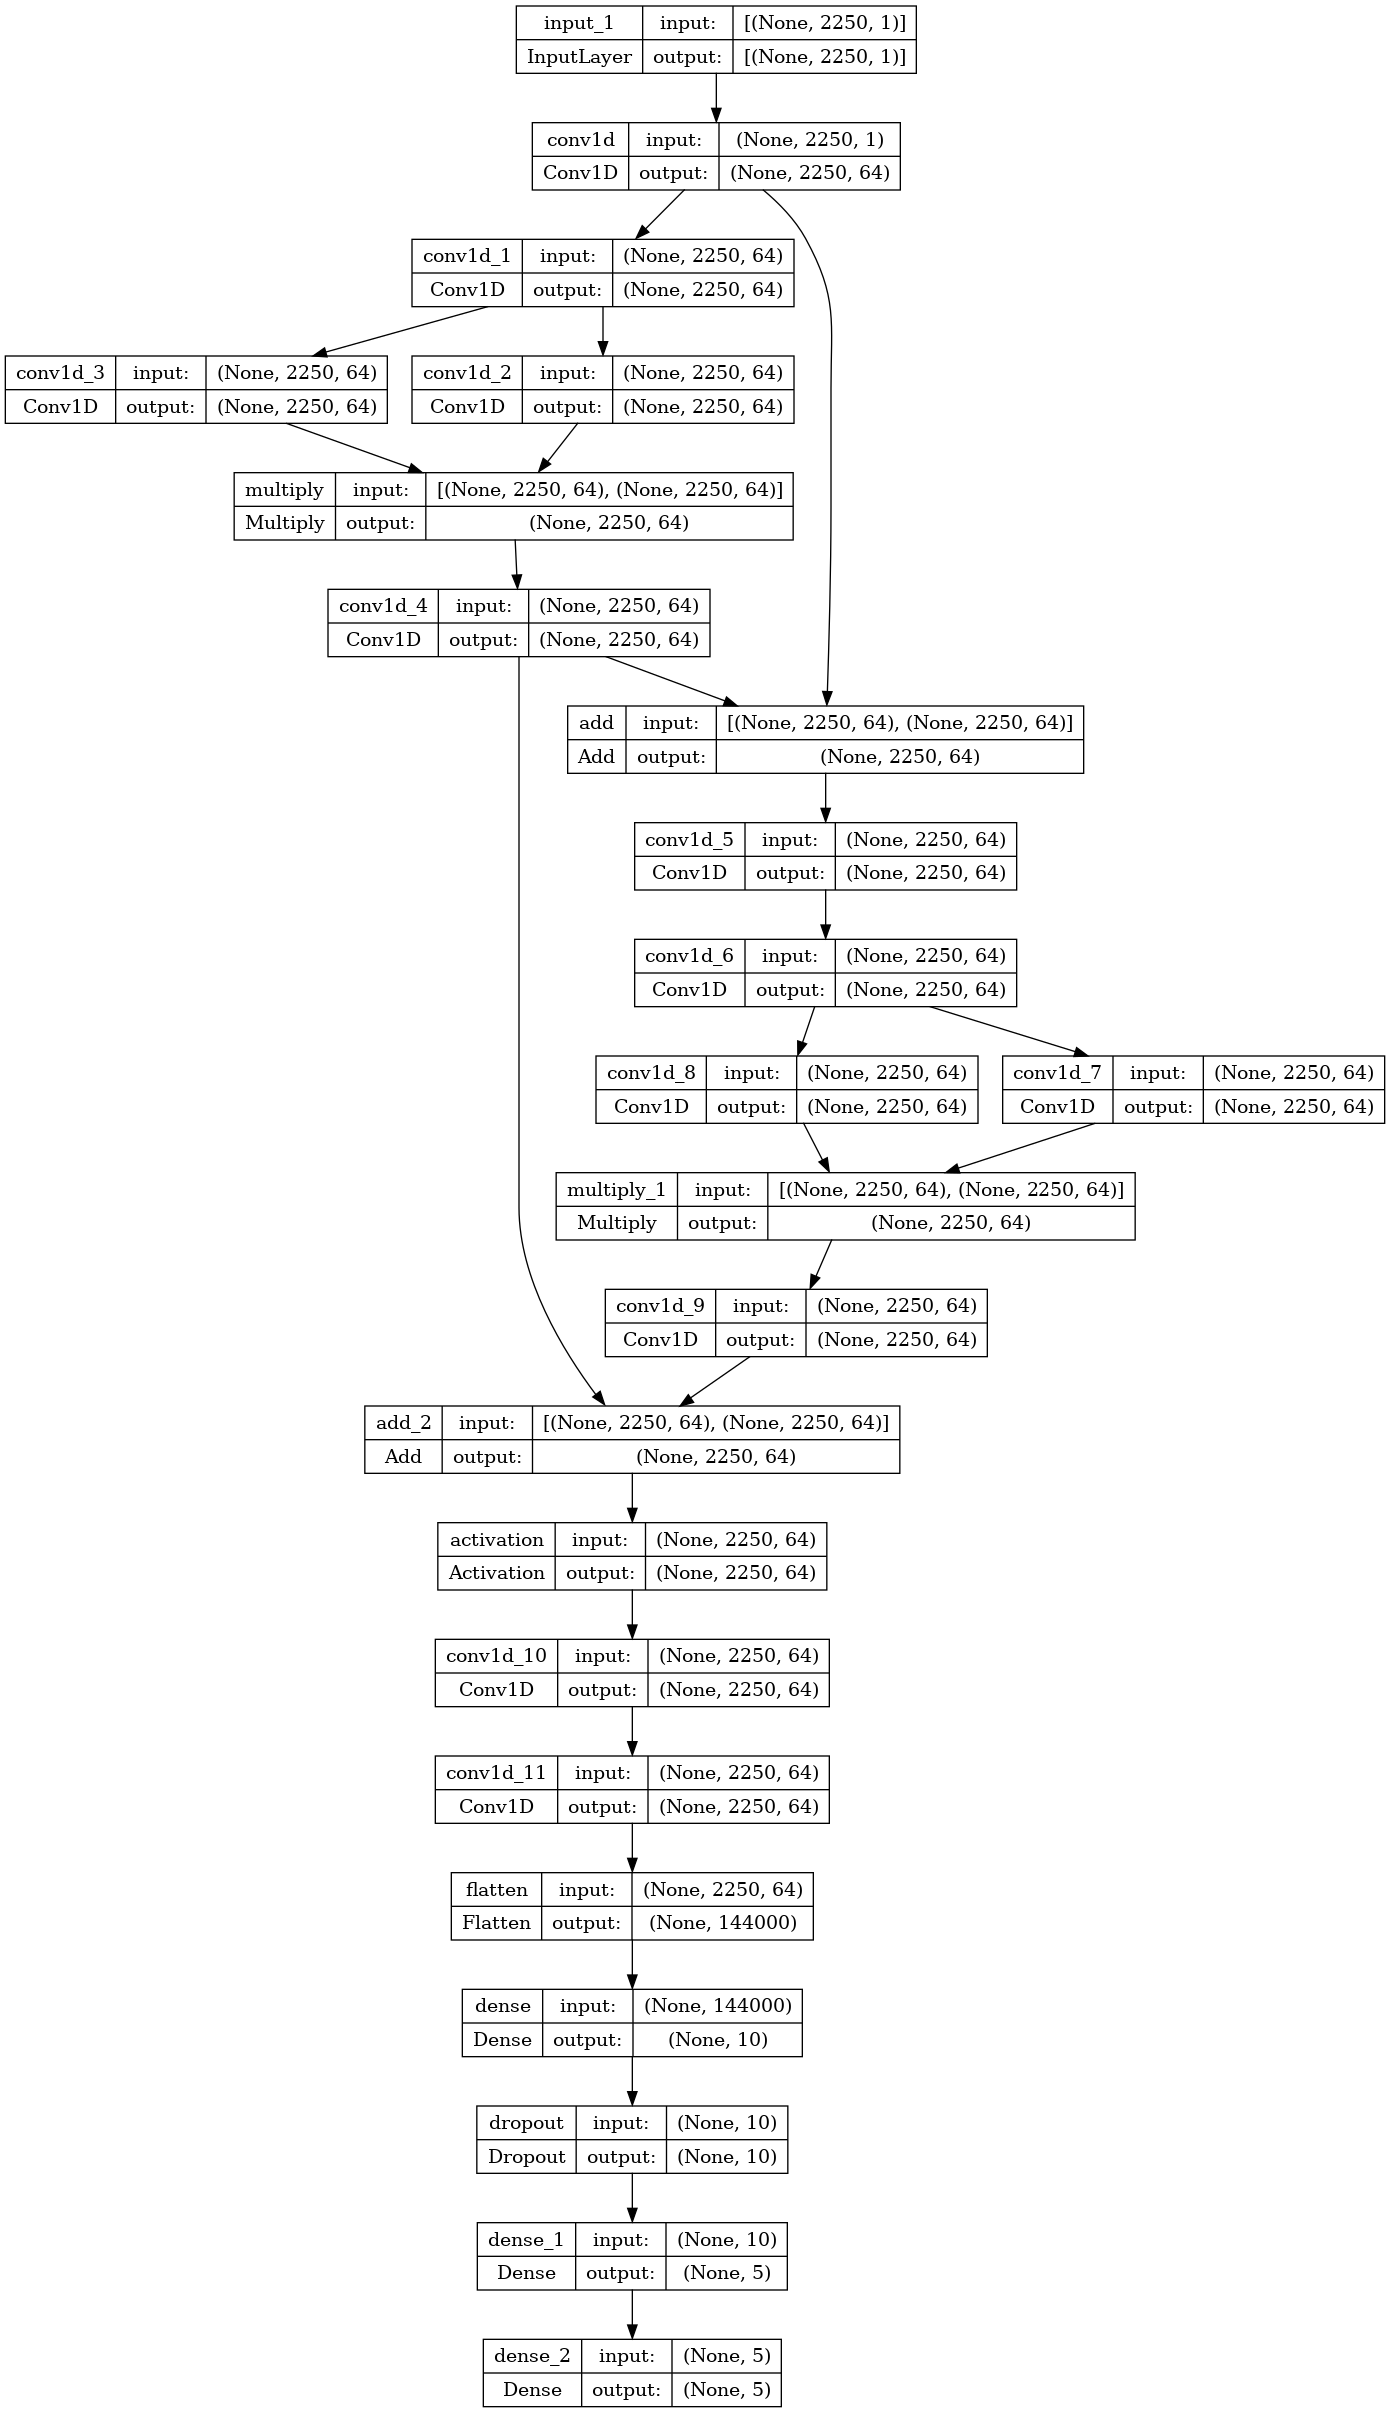

In [7]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [13]:
from sklearn.model_selection import train_test_split
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.001,          
    patience=5,            
    min_lr=1e-6 )          

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


# Train the model with the learning rate reduction callback
history= model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")


Epoch 1/100
16/16 [==============================] - 19s 124ms/step - loss: 1.5994 - accuracy: 0.2324 - val_loss: 1.5992 - val_accuracy: 0.2109 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 80ms/step - loss: 1.5826 - accuracy: 0.2578 - val_loss: 1.5526 - val_accuracy: 0.3672 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 1s 68ms/step - loss: 1.5289 - accuracy: 0.3145 - val_loss: 1.5141 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 1s 77ms/step - loss: 1.4926 - accuracy: 0.3301 - val_loss: 1.4953 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 1s 77ms/step - loss: 1.4647 - accuracy: 0.4277 - val_loss: 1.4641 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 1s 63ms/step - loss: 1.3696 - accuracy: 0.5215 - val_loss: 1.3365 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 1s 77ms/step - 

In [14]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
#loaded_array = np.load('my_array.npy')

# Making 8 layers of Wavenet

In [10]:
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D
from keras.models import Model
def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal',
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      activation='sigmoid'
                      )(x)
    z = Multiply()([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1)(z)
    res = Add()([skip, x])
    return res, skip
x = Input(shape=input_shape)
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal')(x)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add()(skip_connections)
out = Activation('relu')(out)
out = Conv1D(target,1, padding='same', activation='relu')(out)
out = Conv1D(target,1 , padding='same', activation='relu')(out)
out = GlobalAveragePooling1D()(out)
out = Activation(activation)(out)

model = Model(x, out)  
model.compile(optimizer='adam', 
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2250, 1)]    0           []                               
                                                                                                  
 conv1d_37 (Conv1D)             (None, 2250, 64)     192         ['input_3[0][0]']                
                                                                                                  
 conv1d_38 (Conv1D)             (None, 2250, 64)     8256        ['conv1d_37[0][0]']              
                                                                                                  
 conv1d_39 (Conv1D)             (None, 2250, 64)     8256        ['conv1d_37[0][0]']              
                                                                                            

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

checkpoint_path = 'best.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

import numpy as np
# from focal_loss import SparseCategoricalFocalLoss
from sklearn.model_selection import train_test_split

# Train the model
batch_size = 16
epochs = 100

model.fit(X_train, y_train,callbacks=[checkpoint],validation_split=.2,epochs=epochs ,class_weight=class_weights, batch_size=batch_size)

# Googlenet and ResNet 

In [29]:
import tensorflow as tf
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, add,Multiply, Dense, Dropout, GlobalAveragePooling1D, Flatten, MaxPooling1D, Concatenate
from keras.models import Model

# WaveNet

def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal',
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      activation='sigmoid'
                      )(x)
    z = Multiply()([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1)(z)
    res = Add()([skip, x])
    return res, skip
inputs = Input(shape=input_shape)
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal')(inputs)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add()(skip_connections)
out = Activation('relu')(out)
out = Conv1D(target,1, padding='same', activation='relu')(out)
out = Conv1D(target,1 , padding='same', activation='relu')(out)
out = Flatten()(out)

# GoogleNet

#Convolutional layers

x = Conv1D (64, 7, strides= 2, padding='same',activation='relu')(inputs)
x = MaxPooling1D (pool_size= 3 , strides= 2, padding='same')(x)
#x= tf.nn.local_response_normalization(x)
x = Conv1D (64,1, padding='same', activation='relu')(x)
x = Conv1D(192, 3, strides= 1, padding='same',activation='relu')(x)
x=  MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x)

#Inception_block

def inception (x,f1,f2,f3,f4,f5,f6):
    
    x1 = Conv1D(f1,1 ,strides= 1,padding='same',activation='relu')(x)

    x2 = Conv1D(f2, 1, strides= 1, padding='same',activation='relu')(x)
    x3 = Conv1D(f3, 3, strides= 1, padding='same',activation='relu')(x2)

    x4 = Conv1D(f4, 1, strides= 1 ,padding='same',activation='relu')(x)
    x5 = Conv1D(f5, 5, strides= 1 ,padding='same',activation='relu')(x4)

    x6 = MaxPooling1D (pool_size= 3, strides= 1, padding='same')(x)
    x7 = Conv1D(f6, 1,strides= 1, padding='same',activation='relu')(x6)

    concatenated = Concatenate()([x1, x3, x5, x7])

    return concatenated

x= inception(x,64,96,128,16,32,32)
x=inception(x,128,128,192,32,96,64)

x=  MaxPooling1D (pool_size=3, strides= 2, padding='same')(x)

x1= inception(x,192,96,208,16,48,64)

x2= inception(x1,160,112,224,24,64,64)

x3= inception(x2,128,128,256,24,64,64)

x4= inception(x3,112,144,288,32,64,64)

x5= inception(x4,256,160,320,32,128,128)

x5= MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x5)

x5 =inception(x5,256,160,320,32,128,128)
x5 =inception(x5,384,192,384,48,128,128)

# Output layer

# Output 1

y1= AveragePooling1D (pool_size= 5, strides= 3)(x1)
y1 = Conv1D(128, 1, strides= 1, padding='same',activation='relu')(y1)
y1 = Flatten()(y1)

# Output 2

y2= AveragePooling1D(pool_size= 5, strides= 3)(x4)
y2 = Conv1D(128, 1, strides= 1,padding='same',activation='relu')(y2)
y2 = Flatten()(y2)

# Output 3

x5 =AveragePooling1D(pool_size= 7, strides= 1)(x5)
x5 = Flatten()(x5)

x12= Concatenate()([x5,out])

x12= Dense(10,activation='relu')(x12)
x12= Dropout(0.5)(x12)
x12= Dense(5,activation='relu')(x12)
output = Dense(5, activation='softmax')(x12)

model=Model(inputs=inputs,outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 2250, 1)]    0           []                               
                                                                                                  
 conv1d_1489 (Conv1D)           (None, 2250, 64)     192         ['input_40[0][0]']               
                                                                                                  
 conv1d_1516 (Conv1D)           (None, 1125, 64)     512         ['input_40[0][0]']               
                                                                                                  
 conv1d_1490 (Conv1D)           (None, 2250, 64)     8256        ['conv1d_1489[0][0]']            
                                                                                           

In [31]:
from sklearn.model_selection import train_test_split
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Perform train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.001,          
    patience=5,            
    min_lr=1e-6 )          

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


# Train the model with the learning rate reduction callback
history= model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/100
16/16 [==============================] - 2s 147ms/step - loss: 0.5527 - accuracy: 0.7832 - val_loss: 0.5319 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 2/100
16/16 [==============================] - 2s 108ms/step - loss: 0.5496 - accuracy: 0.7812 - val_loss: 0.5318 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 3/100
16/16 [==============================] - 2s 107ms/step - loss: 0.5372 - accuracy: 0.7891 - val_loss: 0.5317 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 4/100
16/16 [==============================] - 2s 109ms/step - loss: 0.5705 - accuracy: 0.7617 - val_loss: 0.5317 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 5/100
16/16 [==============================] - 2s 108ms/step - loss: 0.5949 - accuracy: 0.7539 - val_loss: 0.5316 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 6/100
16/16 [==============================] - 2s 108ms/step - loss: 0.5536 - accuracy: 0.7598 - val_loss: 0.5316 - val_accuracy: 0.8906 - lr: 1.0000e-06
Epoch 7/100
16/16 [=====================

# Using K Fold Cross Validation

In [7]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, add,Multiply, Dense, Dropout, GlobalAveragePooling1D, Flatten, MaxPooling1D, Concatenate
from keras.models import Model

# Define a function for our model so we can call it in cross_val_score
def create_model():
    def residual_block(x, i):
        tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal',
                      activation='tanh'
                      )(x)
        sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      activation='sigmoid'
                      )(x)
        z = Multiply()([tanh_out, sigm_out])
        skip = Conv1D(n_filters, 1)(z)
        res = Add()([skip, x])
        return res, skip
    inputs = Input(shape=input_shape)
    skip_connections = []
    out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal')(inputs)
    for i in range(1, dilation_depth + 1):
        out, skip = residual_block(out,i)
        skip_connections.append(skip)
    out = Add()(skip_connections)
    out = Activation('relu')(out)
    out = Conv1D(target,1, padding='same', activation='relu')(out)
    out = Conv1D(target,1 , padding='same', activation='relu')(out)
    out = Flatten()(out)

    # GoogleNet

   #Convolutional layers

    x = Conv1D (64, 7, strides= 2, padding='same',activation='relu')(inputs)
    x = MaxPooling1D (pool_size= 3 , strides= 2, padding='same')(x)

    x = Conv1D (64,1, padding='same', activation='relu')(x)
    x = Conv1D(192, 3, strides= 1, padding='same',activation='relu')(x)
    x=  MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x)

    #Inception_block

    def inception (x,f1,f2,f3,f4,f5,f6):
    
        x1 = Conv1D(f1,1 ,strides= 1,padding='same',activation='relu')(x)

        x2 = Conv1D(f2, 1, strides= 1, padding='same',activation='relu')(x)
        x3 = Conv1D(f3, 3, strides= 1, padding='same',activation='relu')(x2)

        x4 = Conv1D(f4, 1, strides= 1 ,padding='same',activation='relu')(x)
        x5 = Conv1D(f5, 5, strides= 1 ,padding='same',activation='relu')(x4)

        x6 = MaxPooling1D (pool_size= 3, strides= 1, padding='same')(x)
        x7 = Conv1D(f6, 1,strides= 1, padding='same',activation='relu')(x6)

        concatenated = Concatenate()([x1, x3, x5, x7])

        return concatenated

    x= inception(x,64,96,128,16,32,32)
    x=inception(x,128,128,192,32,96,64)

    x=  MaxPooling1D (pool_size=3, strides= 2, padding='same')(x)

    x1= inception(x,192,96,208,16,48,64)

    x2= inception(x1,160,112,224,24,64,64)

    x3= inception(x2,128,128,256,24,64,64)

    x4= inception(x3,112,144,288,32,64,64)

    x5= inception(x4,256,160,320,32,128,128)

    x5= MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x5)

    x5 =inception(x5,256,160,320,32,128,128)
    x5 =inception(x5,384,192,384,48,128,128)

    # Output layer

    # Output 1

    y1= AveragePooling1D (pool_size= 5, strides= 3)(x1)
    y1 = Conv1D(128, 1, strides= 1, padding='same',activation='relu')(y1)
    y1 = Flatten()(y1)

   # Output 2

    y2= AveragePooling1D(pool_size= 5, strides= 3)(x4)
    y2 = Conv1D(128, 1, strides= 1,padding='same',activation='relu')(y2)
    y2 = Flatten()(y2)

   # Output 3

    x5 =AveragePooling1D(pool_size= 7, strides= 1)(x5)
    x5 = Flatten()(x5)

    x12= Concatenate()([x5,out])

    x12= Dense(10,activation='relu')(x12)
    x12= Dropout(0.5)(x12)
    x12= Dense(5,activation='relu')(x12)
    output = Dense(5, activation='softmax')(x12)

    model=Model(inputs=inputs,outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# create model
my_keras_model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=0)


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.pipeline import Pipeline

# define the pipeline to include scaling and the model. 
#This pipeline will be the input to cross_val_score, instead of the model. 

#from sklearn.preprocessing import MinMaxScaler

steps = list()
#steps.append(('scaler', MinMaxScaler()))
steps.append(('model', my_keras_model))
pipeline = Pipeline(steps=steps)


# Define the crossvalidation process to be used inside cross_val_score evaluation
cv = KFold(n_splits=10, random_state=32, shuffle=True)

# evaluate the model - 
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1)

for i in range(0,len(scores)):
    print("Accuracy for " + str(i) + " no. split is: ", scores[i])

# report performance
print('Accuracy: ', (np.mean(scores)))

# from sklearn.model_selection import cross_validate

# # Assuming you have defined your pipeline as "pipeline"
# # and X, y, cv are your feature data, target data, and cross-validation strategy, respectively.

# # Perform cross-validation and get evaluation metrics for each fold
# scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss'}
# results = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=1, return_train_score=True)

# # Access the metrics for each fold
# accuracy_scores = results['test_accuracy']
# log_loss_scores = -results['test_log_loss']  # Convert negative log loss to positive
# train_accuracy_scores = results['train_accuracy']

# # Compute validation accuracy for each fold
# validation_accuracy_scores = [(train + test) / 2 for train, test in zip(train_accuracy_scores, accuracy_scores)]

# # Print the evaluation metrics for each fold
# for fold_num, (acc_score, val_acc_score, log_loss_score) in enumerate(zip(accuracy_scores, validation_accuracy_scores, log_loss_scores), 1):
#     print(f"Fold {fold_num}: Accuracy = {acc_score:.4f}, Validation Accuracy = {val_acc_score:.4f}, Log Loss = {log_loss_score:.4f}")


/tmp/ipykernel_28/1297458526.py:120: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  my_keras_model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=32, verbose=0)


3/3 [==============================] - 2s 32ms/step
Accuracy for 0 no. split is:  0.5
Accuracy for 1 no. split is:  0.75
Accuracy for 2 no. split is:  0.45
Accuracy for 3 no. split is:  0.6625
Accuracy for 4 no. split is:  0.6375
Accuracy for 5 no. split is:  0.8375
Accuracy for 6 no. split is:  0.25
Accuracy for 7 no. split is:  0.7125
Accuracy for 8 no. split is:  0.9
Accuracy for 9 no. split is:  0.8375
Accuracy:  0.65375


In [4]:
import tensorflow as tf
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, add,Multiply, Dense, Dropout, GlobalAveragePooling1D, Flatten, MaxPooling1D, Concatenate
from keras.models import Model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cv = KFold(n_splits=10, shuffle=True, random_state=32)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = [] #save accuracy from each fold
loss_per_fold = []
all_histories = []

#Train the model for each split (fold)
#We will define the model inside the for loop as we want to initialize and 
#compile it for each fold. 
#We also need to scale values for each fold inside the loop
from sklearn.preprocessing import MinMaxScaler

for train, test in cv.split(X, y):

    print('   ')
    print(f'Training for fold {fold_no} ...')

    #Scale data
    #scaler = MinMaxScaler()
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)
#     scaler.fit(train_X)
#     train_X = scaler.transform(train_X)
#     test_X = scaler.transform(test_X)
    
    
    #Define the model - inside the loop so it trains from scratch for each fold
    #If defined outside, each fold training starts at where it left off at the previous fold
    #calling it as model2 instead of model to make sure no information from our
    #previous example is carried over (without restarting the kernel)
    def residual_block(x, i):
        tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal',
                      activation='tanh'
                      )(x)
        sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      activation='sigmoid'
                      )(x)
        z = Multiply()([tanh_out, sigm_out])
        skip = Conv1D(n_filters, 1)(z)
        res = Add()([skip, x])
        return res, skip
    inputs = Input(shape=input_shape)
    skip_connections = []
    out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal')(inputs)
    for i in range(1, dilation_depth + 1):
        out, skip = residual_block(out,i)
        skip_connections.append(skip)
    out = Add()(skip_connections)
    out = Activation('relu')(out)
    out = Conv1D(target,1, padding='same', activation='relu')(out)
    out = Conv1D(target,1 , padding='same', activation='relu')(out)
    out = Flatten()(out)

    # GoogleNet

   #Convolutional layers

    x = Conv1D (64, 7, strides= 2, padding='same',activation='relu')(inputs)
    x = MaxPooling1D (pool_size= 3 , strides= 2, padding='same')(x)

    x = Conv1D (64,1, padding='same', activation='relu')(x)
    x = Conv1D(192, 3, strides= 1, padding='same',activation='relu')(x)
    x=  MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x)

    #Inception_block

    def inception (x,f1,f2,f3,f4,f5,f6):
    
        x1 = Conv1D(f1,1 ,strides= 1,padding='same',activation='relu')(x)

        x2 = Conv1D(f2, 1, strides= 1, padding='same',activation='relu')(x)
        x3 = Conv1D(f3, 3, strides= 1, padding='same',activation='relu')(x2)

        x4 = Conv1D(f4, 1, strides= 1 ,padding='same',activation='relu')(x)
        x5 = Conv1D(f5, 5, strides= 1 ,padding='same',activation='relu')(x4)

        x6 = MaxPooling1D (pool_size= 3, strides= 1, padding='same')(x)
        x7 = Conv1D(f6, 1,strides= 1, padding='same',activation='relu')(x6)

        concatenated = Concatenate()([x1, x3, x5, x7])

        return concatenated

    x= inception(x,64,96,128,16,32,32)
    x=inception(x,128,128,192,32,96,64)

    x=  MaxPooling1D (pool_size=3, strides= 2, padding='same')(x)

    x1= inception(x,192,96,208,16,48,64)

    x2= inception(x1,160,112,224,24,64,64)

    x3= inception(x2,128,128,256,24,64,64)

    x4= inception(x3,112,144,288,32,64,64)

    x5= inception(x4,256,160,320,32,128,128)

    x5= MaxPooling1D (pool_size= 3, strides= 2, padding='same')(x5)

    x5 =inception(x5,256,160,320,32,128,128)
    x5 =inception(x5,384,192,384,48,128,128)

    # Output layer

    # Output 1

    y1= AveragePooling1D (pool_size= 5, strides= 3)(x1)
    y1 = Conv1D(128, 1, strides= 1, padding='same',activation='relu')(y1)
    y1 = Flatten()(y1)

   # Output 2

    y2= AveragePooling1D(pool_size= 5, strides= 3)(x4)
    y2 = Conv1D(128, 1, strides= 1,padding='same',activation='relu')(y2)
    y2 = Flatten()(y2)

   # Output 3

    x5 =AveragePooling1D(pool_size= 7, strides= 1)(x5)
    x5 = Flatten()(x5)

    x12= Concatenate()([x5,out])

    x12= Dense(10,activation='relu')(x12)
    x12= Dropout(0.5)(x12)
    x12= Dense(5,activation='relu')(x12)
    output = Dense(5, activation='softmax')(x12)

    model2=Model(inputs=inputs,outputs=output)
    model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.001,          
    patience=5,            
    min_lr=1e-6 )          

    # Define the model checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint('best_model_fold_'+str(fold_no)+'.h5', monitor='val_accuracy', save_best_only=True)

    # Define the early stopping callback to stop training if validation loss does not improve
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
   
  # Fit data to model
    history = model2.fit(X_train, y_train,validation_data=(X_val,y_val), batch_size=32, epochs=100,callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])
    all_histories.append(history.history)
    #Save model trained on each fold.
    #model2.save('models/model_fold_'+str(fold_no)+'.h5')   

    # Evaluate the model - report accuracy and capture it into a list for future reporting
    best_model = tf.keras.models.load_model('best_model_fold_'+str(fold_no)+'.h5')
    loss, accuracy = best_model.evaluate(X_test, y_test)
    #loss,accuracy = model2.evaluate(X_test, y_test, verbose=0)
    acc_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss * 100)
    
    fold_no = fold_no + 1

for i in range(0,len(acc_per_fold)):
    print("Accuracy for " + str(i) + " no. fold is: ", acc_per_fold[i])
for i in range(0,len(loss_per_fold)):
    print("Loss for " + str(i) + " no. fold is: ", loss_per_fold[i])


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

   
Training for fold 1 ...
Epoch 1/100
23/23 [==============================] - 57s 375ms/step - loss: 1.4554 - accuracy: 0.2944 - val_loss: 1.0911 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 3s 137ms/step - loss: 1.1444 - accuracy: 0.4958 - val_loss: 0.8745 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 3s 146ms/step - loss: 0.9973 - accuracy: 0.5792 - val_loss: 0.7395 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 2s 109ms/step - loss: 0.9372 - accuracy: 0.6000 - val_loss: 0.6369 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 3s 142ms/step - loss: 0.8683 - accuracy: 0.6069 - val_loss: 0.6143 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 2s 109ms/step - loss: 0.8510 - accuracy: 0.6014 - val_loss: 0.7122 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 7/100
23/23 [================

4/4 [==============================] - 2s 34ms/step
Classification Report:
                        precision    recall  f1-score   support

       aorticstenosis       0.96      0.96      0.96        24
 mitral regurgitation       0.89      0.94      0.91        17
      mitral stenosis       1.00      0.96      0.98        26
mitral valve prolapse       0.88      0.94      0.91        16
               normal       1.00      0.94      0.97        17

             accuracy                           0.95       100
            macro avg       0.95      0.95      0.95       100
         weighted avg       0.95      0.95      0.95       100



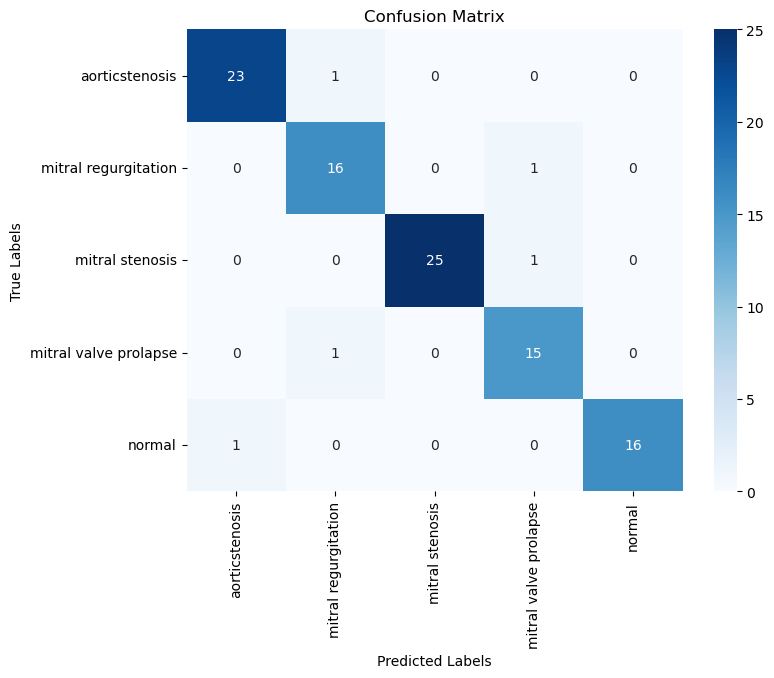

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


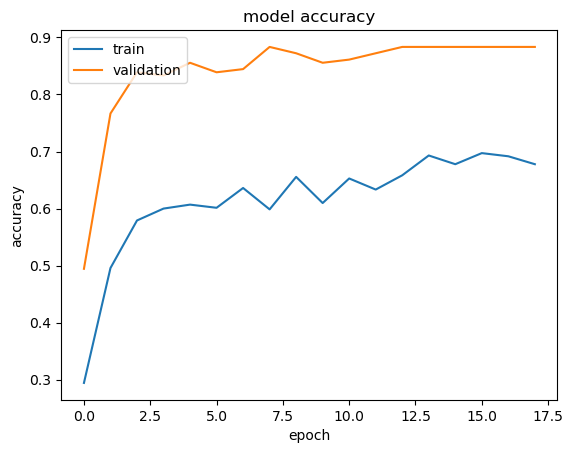

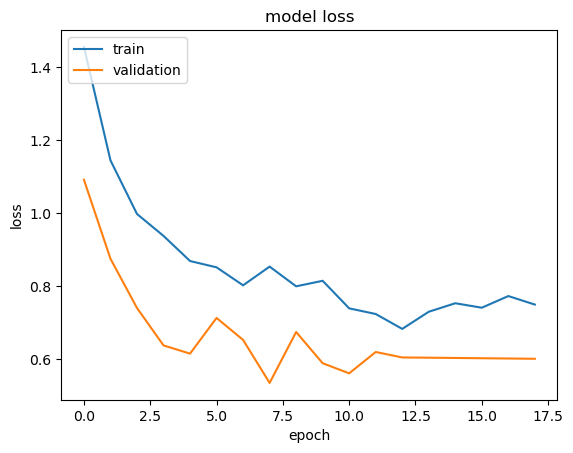

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  #to enhance the visual appearance of the plots. 
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
best_model = tf.keras.models.load_model('best_model_fold_9.h5')
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(['aorticstenosis','mitral regurgitation','mitral stenosis','mitral valve prolapse','normal'])
report = classification_report(y_test, predicted_classes , target_names=class_names)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes )
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# The annot=True argument displays the values inside the heatmap cells. 
#fmt="d" specifies that the values should be displayed as integers. 
#The cmap="Blues" argument sets the color map to shades of blue.
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(all_histories[0].keys())
# summarize history for accuracy
plt.plot(all_histories[0]['accuracy'])
plt.plot(all_histories[0]['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(all_histories[0]['loss'])
plt.plot(all_histories[0]['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
